In [1]:
import sys
sys.path.append("C:/Users/Nikhil/Google Drive Work/MyPythonLibraries/more/more")

In [2]:
#import hyperopt_helper.MyObjective as mo
import hyperopt_helper as hh
import viz_helper as vh
from scikit_helper.cluster import KMeansHelper as kmh
from scikit_helper.cluster import AgglomerativeHelper as agh

In [3]:
from sklearn.cluster import KMeans
from sklearn import datasets
import pandas as pd

In [4]:
import hyperopt
import numpy as np

def find_best_hyper_params(space, objective, max_evals=100, random_state=None):    
    trials = hyperopt.Trials()
    best = hyperopt.fmin(
                        fn=objective,
                        space=space,
                        algo=hyperopt.rand.suggest,
                        max_evals=max_evals,
                        rstate=np.random.RandomState(seed=random_state))
    return best

def train_best_model(space, objective, max_evals=100, random_state=None):
    best = find_best_hyper_params(space, objective, max_evals, random_state)
    
    # merge subset of hyper-parameters provided by hyperopt with hyper-parameters 
    # provided by the user
    #hyper_params = best
    hyper_params = hyperopt.space_eval(space, best)
    hyper_params.update(objective._const_params)
    
    # drop `use_best_model` because we are going to use entire dataset for 
    # training of the final model
    hyper_params.pop('use_best_model', None)
    
    model = objective.model.set_params(**hyper_params)
    model.fit(X)
    
    return model, hyper_params

In [5]:
iris = datasets.load_iris()
X = iris.data
y = iris.target

kmeans = KMeans(n_clusters=8)

In [6]:
# Define the parameters that will not change during huperparameter optimization
const_params = dict({'init': 'k-means++'
                     ,'random_state': 101
                     ,'n_jobs': -1
                     ,'algorithm': 'auto'
                    })

In [8]:
# Define the loss function that has to be minimized during hyper parameter optimization.
def loss_function (model, X, y):
    """
    loss_function must have 3 arguments for 
    (1)  Model
    (2) X (Features)
    (3) y (labels) - Do not have to use this internally for unsupervised problems but needs to be in the argument list
    
    Also, any libraries used specifically must be imported within this function.
    """
    import sklearn.metrics as mt
    model.fit(X)
    measure_s = -mt.silhouette_score(X, model.labels_,random_state=101)
    
    #cv_results = cross_validate(self.model, self.X, self.y, cv=self.cv, scoring = self.scoring)
    #return(-np.mean(cv_results['test_AUC'] + cv_results['test_Accuracy']))    
    #return(-np.mean(cv_results['test_Silhoutte']))    
    
    return(measure_s)

In [9]:
objective = hh.MyObjective(model = kmeans, X=X, y=None
                           ,const_params=const_params 
                           ,loss_fun=loss_function)

In [10]:
space = {'n_clusters': hyperopt.hp.choice('n_clusters', np.arange(3, 11, dtype=int)),
         'n_init': hyperopt.hp.choice('n_init', np.arange(10, 100, dtype=int)),
         'max_iter': hyperopt.hp.choice('max_iter', np.arange(300, 500, dtype=int)) }

In [11]:
model, best_params = train_best_model(space=space, objective=objective, max_evals=20, random_state=101)

evaluating params={'max_iter': 472, 'n_clusters': 6, 'n_init': 39, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3648340039670018
evaluated 1 times
evaluating params={'max_iter': 426, 'n_clusters': 5, 'n_init': 62, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.4887488870931048
evaluated 2 times
evaluating params={'max_iter': 442, 'n_clusters': 3, 'n_init': 63, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 3 times
evaluating params={'max_iter': 309, 'n_clusters': 3, 'n_init': 95, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 4 times
evaluating params={'max_iter': 337, 'n_clusters': 7, 'n_init': 61, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3568618172536361
evaluated 5 times
evaluating params={'max_iter': 485, 'n_clusters': 10, 'n_init': 7

In [12]:
best_params

{'max_iter': 442,
 'n_clusters': 3,
 'n_init': 63,
 'init': 'k-means++',
 'random_state': 101,
 'n_jobs': -1,
 'algorithm': 'auto'}

In [13]:
model.cluster_centers_

array([[5.9016129 , 2.7483871 , 4.39354839, 1.43387097],
       [5.006     , 3.428     , 1.462     , 0.246     ],
       [6.85      , 3.07368421, 5.74210526, 2.07105263]])

In [14]:
# # Instantiating Hyperopt_helper
# hyperopt_helper = hh.HyperoptHelper(space=space, objective=objective, max_evals=20, random_state=101)
# model, best_params = hyperopt_helper.train_best_model()
# print(best_params)
# print(model.cluster_centers_)

### Using KMeans Helper Class

In [15]:
kmeans = kmh(X=pd.DataFrame(X, columns=iris.feature_names), n_clusters=8, n_jobs=-1, scaled=False
             , space = space, const_params=const_params, loss_fun = loss_function)


##### **Note that we passed**

1. the constant hyper parameters, 
2. hyperparameers search space and 
3. the desired loss function during the instantiation

**These will be used during Bayesian Hyperparameter Optimization**

In [16]:
kmeans.train_best_model() # Performing Hyperparameter Search using Bayesian Optimization

evaluating params={'max_iter': 472, 'n_clusters': 6, 'n_init': 39, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3648340039670018
evaluated 1 times
evaluating params={'max_iter': 426, 'n_clusters': 5, 'n_init': 62, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.4887488870931048
evaluated 2 times
evaluating params={'max_iter': 442, 'n_clusters': 3, 'n_init': 63, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 3 times
evaluating params={'max_iter': 309, 'n_clusters': 3, 'n_init': 95, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.5528190123564091
evaluated 4 times
evaluating params={'max_iter': 337, 'n_clusters': 7, 'n_init': 61, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}
Loss=-0.3568618172536361
evaluated 5 times
evaluating params={'max_iter': 485, 'n_clusters': 10, 'n_init': 7

In [17]:
kmeans.best_params

{'max_iter': 442,
 'n_clusters': 3,
 'n_init': 63,
 'init': 'k-means++',
 'random_state': 101,
 'n_jobs': -1,
 'algorithm': 'auto'}

In [18]:
kmeans.cluster_means()

labels,0,1,2
sepal length (cm),5.901613,5.006,6.850000
sepal width (cm),2.748387,3.428,3.073684
petal length (cm),4.393548,1.462,5.742105
petal width (cm),1.433871,0.246,2.071053


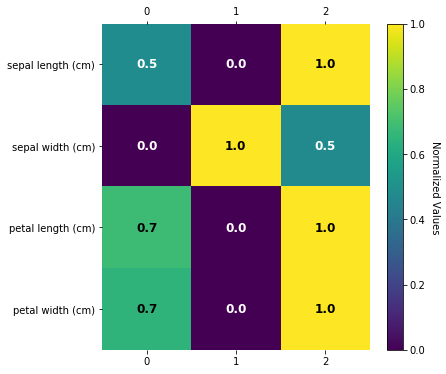

In [19]:
kmeans.plot_means_heatmap(annot=True)

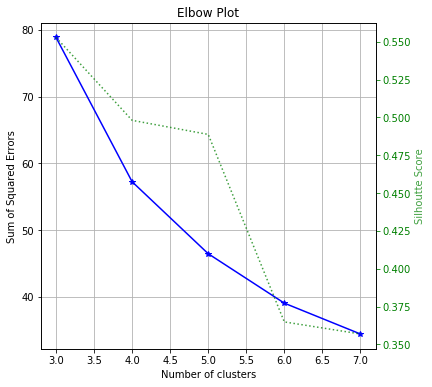

In [20]:
kmeans.plot_elbow_curve(cluster_ranges=[3,4,5,6,7],second_metric='silhoutte',n_jobs=-1)

## Using external hyperparameter optimization

We can use an external optimization engine (instead of using the internal hyperopt optimization engine). 
The following section describes how this can be done.

In [21]:
from skopt.space import Integer, Categorical, Real
from skopt.utils import use_named_args
from skopt import gp_minimize
import skopt.plots

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [30]:
# Preprocessing and Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics as mt

# Define the space
space = [Integer(3, 100, name='n_clusters')
         ,Integer(10, 100, name='n_init')
         ,Integer(300, 500, name='max_iter')
        ]

# Define the objective function (loss function) to be minimized
@use_named_args(space)
def objective(**params):
    kmeans_model = KMeans(init='k-means++',random_state=101,n_jobs=-1,**params)
    std_scl = StandardScaler()
    piped_object = Pipeline([('scale', std_scl),  # do this
                             ('kmeans_model', kmeans_model)]) # and then do this

    piped_object.fit(X)
    
    measure_s = -mt.silhouette_score(X,kmeans_model.labels_,random_state=101)
    return (measure_s)

In [23]:
kmeans_gp = gp_minimize(objective,space
                       ,n_random_starts=10 # 10 random points to start 
                       ,n_calls=25 # pick 25 points total (including n_random_starts) to find optimal combination of hyperparameters
                       ,verbose=True, n_jobs=-1, random_state=101)

Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 0.7526
Function value obtained: -0.1563
Current minimum: -0.1563
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 0.1493
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 0.3674
Function value obtained: -0.1540
Current minimum: -0.5062
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 0.2433
Function value obtained: -0.1144
Current minimum: -0.5062
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 0.1971
Function value obtained: -0.3172
Current minimum: -0.5062
Iteration No: 6 started. 

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 0.5066
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 16 started. Searching for the next optimal point.
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1.6839
Function value obtained: -0.1153
Current minimum: -0.5062
Iteration No: 17 started. Searching for the next optimal point.
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 0.6384
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 18 started. Searching for the next optimal point.
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 0.6549
Function value obtained: -0.2051
Current minimum: -0.5062
Iteration No: 19 started. Searching for the next optimal point.
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 0.7629
Function value obtained: -0.0950
Current minimum: -0.5062
Iteration No: 20 st

C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 0.5688
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 22 started. Searching for the next optimal point.


C:\ProgramData\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 0.7821
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 23 started. Searching for the next optimal point.
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 0.6595
Function value obtained: -0.2531
Current minimum: -0.5062
Iteration No: 24 started. Searching for the next optimal point.
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 0.8103
Function value obtained: -0.5062
Current minimum: -0.5062
Iteration No: 25 started. Searching for the next optimal point.
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 0.6993
Function value obtained: -0.1787
Current minimum: -0.5062


In [24]:
print('Best score: {} | Best params: {}'.format(kmeans_gp.fun, kmeans_gp.x))

Best score: -0.5061527484935536 | Best params: [3, 58, 358]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001EC902B84E0>,
      dtype=object)

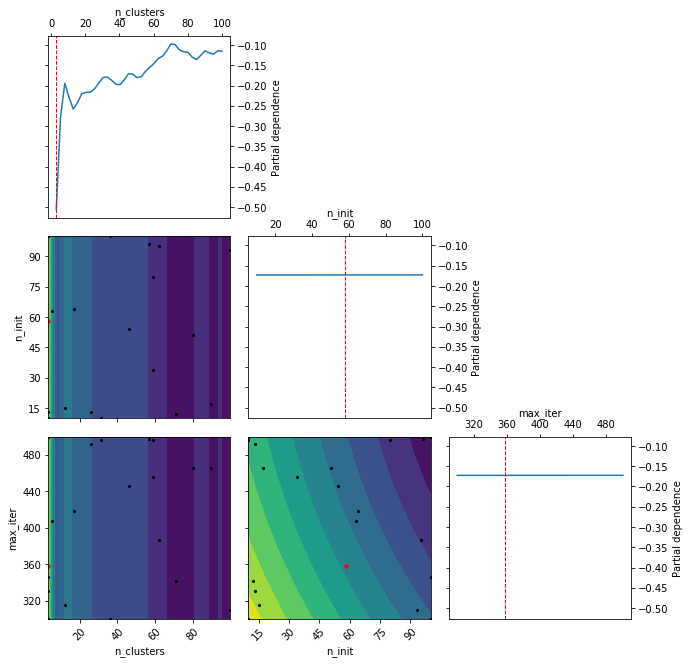

In [25]:
skopt.plots.plot_objective(kmeans_gp, size=3, dimensions=['n_clusters','n_init','max_iter'])

* NOTE that the plot is showing the negative of Silhoutte Score
* From the above partial dependence plot, we see that the the maximum Silhoutte score is obrained at n_clusters = 3 (all other paraneters being kept constant) 

In [34]:
# Prepare model with complete list of "best" parameters
best_params = {'n_clusters':  kmeans_gp.x[0] 
              ,'n_init':  kmeans_gp.x[1]
              ,'max_iter':  kmeans_gp.x[2]
             }
best_params.update(const_params)
print(best_params)
kmeans_best = KMeans(**best_params)

{'n_clusters': 3, 'n_init': 58, 'max_iter': 358, 'init': 'k-means++', 'random_state': 101, 'n_jobs': -1, 'algorithm': 'auto'}


In [27]:
# Update helper object with "best" model 
kmeans.set_model(kmeans_best)

In [28]:
# Train and evaluate as usual
kmeans.train().evaluate_fit()

Silhouette Coefficient: 0.5528190123564091


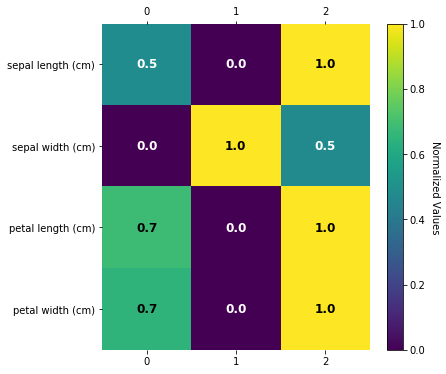

In [31]:
kmeans.plot_means_heatmap(annot=True)

* We get the same results as that obtained by using the internal Hyperopt method. 
* Note however that this may not always be the case as the 2 methods (internal hyperopt and external optimization) may return different values of the "best" hyperparameters